In [3]:
import pandas as pd
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_33559/858885361.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [1]:
ONLY_CS = False
EXCLUDE_TRANSFER = False
csv_read_location = '../data/pivot_CSCurriculumFull.csv'

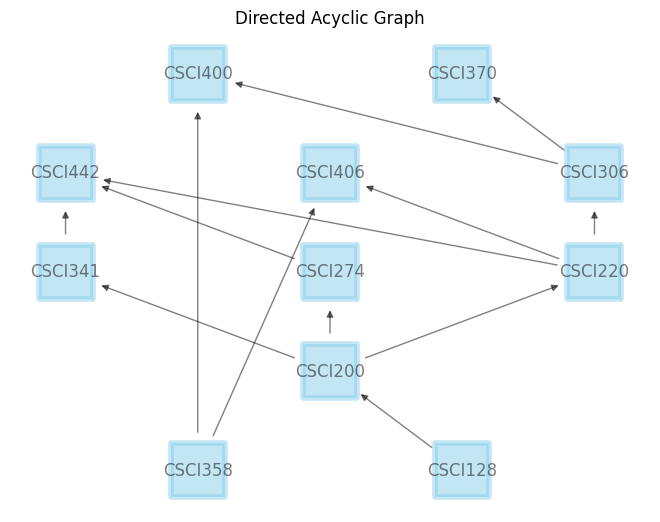

In [4]:
# create dag
reader = pd.read_csv('../dags/dag_simple.csv')
dag = nx.DiGraph()

for i in range(len(reader)):
    dag.add_edge(reader['prereq'][i], reader['class'][i])

for layer, nodes in enumerate(nx.topological_generations(dag)):
    for node in nodes:
        dag.nodes[node]["layer"] = layer

# plot the dag
pos = nx.multipartite_layout(dag,subset_key="layer", align='horizontal')
nx.draw(dag, pos, with_labels=True, node_size=1500, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=4)
plt.title('Directed Acyclic Graph')
plt.show()

# Eligible

Notes about modifications made: 
- All Summer classes are pushed back to Spring (if taken in Summer, eligible to take in Fall)
- All admittance occurs in Fall or Spring (if taken in Summer, pushed forward to Fall)

In [5]:
taken_df = pd.read_csv(csv_read_location)

In [6]:
# use only CS students
if ONLY_CS:
    taken_df = taken_df[taken_df['Department'] == "Computer Science"]

# exclude transfer students
if EXCLUDE_TRANSFER:
    taken_df = taken_df[taken_df['Type'] != 'Tran']

# replace CSCI101 with CSCI128
taken_df['Class'] = taken_df['Class'].replace('CSCI101', 'CSCI128')
taken_df['Class'] = taken_df['Class'].replace('CSCI261', 'CSCI200')
taken_df['Class'] = taken_df['Class'].replace('CSCI262', 'CSCI201')

In [ ]:
# add numerical conversion 
UNIQUE_SEM = 5
taken_df['Taken_Num'] = np.select([
    taken_df['Taken_Semester'] == 'Spring',
    taken_df['Taken_Semester'] == 'Summer One',
    taken_df['Taken_Semester'] == 'Summer Two',
    taken_df['Taken_Semester'] == 'Summer',
    taken_df['Taken_Semester'] == 'Fall'
    ], 
    [taken_df['Taken_Year'] * UNIQUE_SEM, 
    taken_df['Taken_Year'] * UNIQUE_SEM + 1, 
    taken_df['Taken_Year'] * UNIQUE_SEM + 2,
    taken_df['Taken_Year'] * UNIQUE_SEM + 3,
    taken_df['Taken_Year'] * UNIQUE_SEM + 4], 
    default = 'UNKNOWN')

taken_df['Admitted_Num'] = np.select([
    taken_df['Admitted_Semester'] == 'Spring',
    taken_df['Admitted_Semester'] == 'Summer One',
    taken_df['Admitted_Semester'] == 'Summer Two',
    taken_df['Admitted_Semester'] == 'Summer',
    taken_df['Admitted_Semester'] == 'Fall'
    ], 
    [taken_df['Admitted_Year'] * UNIQUE_SEM, 
    taken_df['Admitted_Year'] * UNIQUE_SEM + 1, 
    taken_df['Admitted_Year'] * UNIQUE_SEM + 2,
    taken_df['Admitted_Year'] * UNIQUE_SEM + 3,
    taken_df['Admitted_Year'] * UNIQUE_SEM + 4], 
    default = 'UNKNOWN')

taken_df['Taken_Num'] = taken_df['Taken_Num'].astype(int)

In [32]:
assert(len(taken_df[taken_df['Taken_Num'] == 'UNKNOWN']) == 0)
assert(len(taken_df[taken_df['Admitted_Num'] == 'UNKNOWN']) == 0)

In [33]:
# find in-degrees of dag
in_degrees = dict(dag.in_degree())
in_degrees = dict(sorted(in_degrees.items()))

In [34]:
# create carry-through df
carry_through = pd.DataFrame(columns=['Semester_Num'] + list(in_degrees.keys()))

# find uniques
unique_ids = taken_df['id'].unique()
unique_nums = sorted(taken_df['Taken_Num'].unique())
unique_nums += [int(max(unique_nums)) + 1]

for num in unique_nums: 
    temp = [num] + list(in_degrees.values())
    carry_through = pd.concat([carry_through, pd.DataFrame([temp], columns=carry_through.columns)], ignore_index=True)

carry_through = carry_through.astype({'Semester_Num': 'int32'})
carry_through

,Semester_Num,CSCI128,CSCI200,CSCI220,CSCI274,CSCI306,CSCI341,CSCI358,CSCI370,CSCI400,CSCI406,CSCI442
0,10048,0,1,1,1,1,1,0,1,2,2,3
1,10089,0,1,1,1,1,1,0,1,2,2,3
2,10090,0,1,1,1,1,1,0,1,2,2,3
3,10091,0,1,1,1,1,1,0,1,2,2,3
4,10092,0,1,1,1,1,1,0,1,2,2,3
5,10094,0,1,1,1,1,1,0,1,2,2,3
6,10095,0,1,1,1,1,1,0,1,2,2,3
7,10098,0,1,1,1,1,1,0,1,2,2,3
8,10099,0,1,1,1,1,1,0,1,2,2,3
9,10100,0,1,1,1,1,1,0,1,2,2,3


In [35]:
def out_calc(G,cl):
    if G.has_node(cl):
        return list(G.successors(cl))
    else:
        return []

In [36]:
# create carry-out df
cols = ['id'] + list(carry_through.columns)
carry_out = pd.DataFrame(columns=cols)

In [37]:
admit_df = taken_df[['id', 'Admitted_Num']].drop_duplicates()

In [38]:
for i in unique_ids: 

    # find admit_num for id
    admit_num = admit_df[admit_df['id'] == i]['Admitted_Num'].values[0]

    # create copy and assign 
    temp_df = carry_through.copy()
    temp_df['id'] = i
    temp_df = temp_df[temp_df['Semester_Num'] >= int(admit_num)]

    # find taken records from taken_df
    taken_temp = taken_df[taken_df['id'] == i]
    taken_temp = taken_temp.sort_values(by='Taken_Num')

    # iterate through taken records
    for index, row in taken_temp.iterrows():
        # affect classes
        affected_classes = out_calc(dag, row['Class']) + [row['Class']] # find classes
        for cl in affected_classes:
             # decrement out-degrees for all semesters after the current semester
            temp_df.loc[temp_df['Semester_Num'] > row['Taken_Num'], cl] -= 1
    
    carry_out = pd.concat([carry_out, temp_df], ignore_index=True)

carry_out

,id,Semester_Num,CSCI128,CSCI200,CSCI220,CSCI274,CSCI306,CSCI341,CSCI358,CSCI370,CSCI400,CSCI406,CSCI442
0,134,10089,0,1,1,1,1,1,0,1,2,2,3
1,134,10090,-1,-1,0,0,1,0,0,1,2,2,3
2,134,10091,-1,-1,0,0,1,0,0,1,2,2,3
3,134,10092,-1,-1,0,0,1,0,0,1,2,2,3
4,134,10094,-1,-1,0,0,1,0,0,1,2,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53388,7157,10114,0,1,1,1,1,1,0,1,2,2,2
53389,7157,10115,0,1,1,1,1,1,0,1,2,2,2
53390,7157,10118,0,1,1,1,1,1,0,1,2,2,2
53391,7157,10119,0,1,1,1,1,1,0,1,2,2,2


In [39]:
# convert Semseter_Num as int back into year and semester
carry_out = carry_out.astype({'Semester_Num': 'int32'})
carry_out['Year'] = carry_out['Semester_Num'] // UNIQUE_SEM
carry_out['Semester'] = carry_out['Semester_Num'] % UNIQUE_SEM

carry_out['Semester'] = np.select([
    carry_out['Semester'] == 0,
    carry_out['Semester'] == 1,
    carry_out['Semester'] == 2,
    carry_out['Semester'] == 3, 
    carry_out['Semester'] == 4
    ], 
    ['Spring', 'Summer One', 'Summer Two', 'Summer', 'Fall'], 
    default = 'UNKNOWN')

# clean and concat
carry_out['Year_Semester'] = carry_out['Semester'].astype(str) + ' ' + carry_out['Year'].astype(str)
carry_out = carry_out.drop(columns=['Year', 'Semester'])
carry_out

,id,Semester_Num,CSCI128,CSCI200,CSCI220,CSCI274,CSCI306,CSCI341,CSCI358,CSCI370,CSCI400,CSCI406,CSCI442,Year_Semester
0,134,10089,0,1,1,1,1,1,0,1,2,2,3,Fall 2017
1,134,10090,-1,-1,0,0,1,0,0,1,2,2,3,Spring 2018
2,134,10091,-1,-1,0,0,1,0,0,1,2,2,3,Summer One 2018
3,134,10092,-1,-1,0,0,1,0,0,1,2,2,3,Summer Two 2018
4,134,10094,-1,-1,0,0,1,0,0,1,2,2,3,Fall 2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53388,7157,10114,0,1,1,1,1,1,0,1,2,2,2,Fall 2022
53389,7157,10115,0,1,1,1,1,1,0,1,2,2,2,Spring 2023
53390,7157,10118,0,1,1,1,1,1,0,1,2,2,2,Summer 2023
53391,7157,10119,0,1,1,1,1,1,0,1,2,2,2,Fall 2023


# Plots and Whatnots

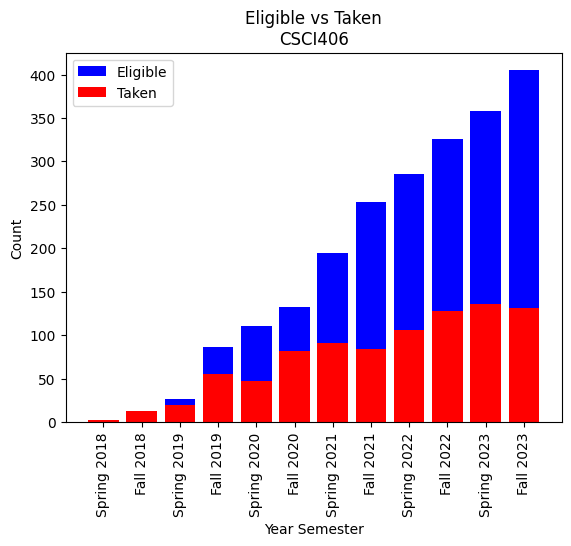

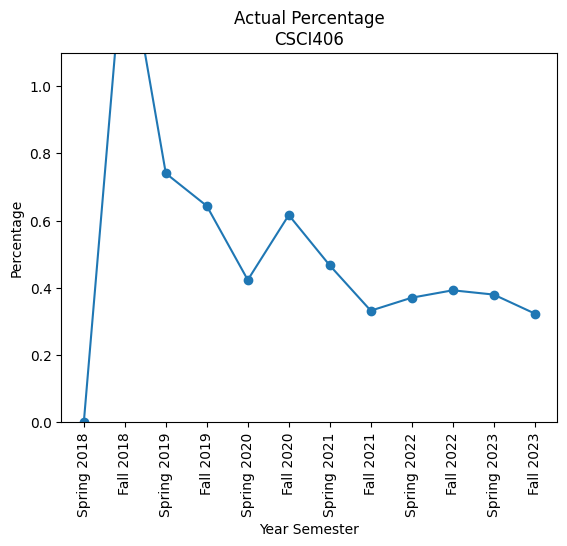

In [42]:
def plot_eligible_to_taken(carry_out, cl):

    # initialize 
    temp_carry = carry_out[['Year_Semester', cl]].copy()
    temp_taken = taken_df[taken_df['Class'] == cl].copy()
    temp_taken.loc[:, 'Year_Semester'] = temp_taken['Taken_Semester'] + ' ' + temp_taken['Taken_Year'].astype(str)
    eligible_dict = { sem:0 for sem in temp_taken['Year_Semester'].unique() }
    taken_dict = {sem: len(temp_taken[temp_taken['Year_Semester'] == sem]) for sem in temp_taken['Year_Semester'].unique()}

    # find eligible
    for ys in eligible_dict.keys():
        eligible_dict[ys] = len(temp_carry[(temp_carry['Year_Semester'] == ys) & (temp_carry[cl] == 0)])
    
    # find actual enrollment
    actual_dict = {sem:0 for sem in temp_taken['Year_Semester'].unique()}
    
    # find actual eligibility
    for sem in actual_dict.keys(): 
        if eligible_dict[sem] != 0:
            actual_dict[sem] = taken_dict[sem] / eligible_dict[sem]
        else:
            actual_dict[sem] = 0

    # First, sort the DataFrame by 'Semester_Num'
    sorted_df = temp_taken.sort_values(by='Taken_Num')

    # Then, select the 'Year_Semester' column and get its unique values
    semester_list = sorted_df['Year_Semester'].unique()
    
    # maintain order
    ordered_actual_dict = {k: actual_dict[k] for k in semester_list}
    order_eligible_dict = {k: eligible_dict[k] for k in semester_list}
    order_taken_dict = {k: taken_dict[k] for k in semester_list}

    # plot hist
    plt.bar(order_eligible_dict.keys(), order_eligible_dict.values(), color='b', label='Eligible')
    plt.bar(order_taken_dict.keys(), order_taken_dict.values(), color='r', label='Taken')
    plt.xlabel('Year Semester')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.title(f'Eligible vs Taken\n{cl}')
    plt.legend()
    plt.show()

    # plot line graph of actual
    plt.plot(ordered_actual_dict.keys(), ordered_actual_dict.values(), marker='o')
    plt.xlabel('Year Semester')
    plt.ylabel('Percentage')
    plt.ylim(0, 1.1)
    plt.xticks(rotation=90)
    plt.title(f'Actual Percentage\n{cl}')
    plt.show()

for cl in ['CSCI406']:
    plot_eligible_to_taken(carry_out, cl)
    